# Lab 3-1: REINFORCE
    In this lab, you need to implement a REINFORCE algorithm with Tensorflow and solve OpenAI Gym CartPole-v0

In [1]:
from cartpole_env import *

import numpy as np
import tensorflow as tf

from collections import namedtuple, deque

# Define the data structure of experience
Experience = namedtuple('Experience', 'state action reward next_state done')

## Implement ```discount``` function to compute discounted reward

In [2]:
def discount(rewards, gamma):
    '''
    param rewards: a rewards numpy array
    param gamma: discount factor
    '''
    discounted_rewards = np.zeros_like(rewards)
    
    # TODO: Calculate discounted rewards
    discounted_rewards = rewards
    s = 0
    for i in reversed(range(len(rewards))):
        #
        # reward = [1, 2, 3]
        # discounted_rewards = [
        #    1 + gamma * 2 + gamma * gamma * 3, 
        #    2 + gamma * 3,
        #    3 ]
        #
        
        s = s * gamma + rewards[i]
        discounted_rewards[i] = s

    return discounted_rewards

## Implement ```do_rollout``` function to collect rollout

In [3]:
def do_rollout(env, policy, render=False):
    '''
    Collect a rollout from env with policy
    
    param env: RL Environment
    param policy: a function parameterized by environment state, return a action
    return a list of (state, action, reward, next_state, done)
    '''
    # Initialize done as False
    done = False
    
    # Reset the environment and get the initial state
    state = env.reset()
    
    # Empty list
    rollout = []
    
    while not done:
        action = policy(state)
        next_state, reward, done, info = env.step(action)
        
        # Render the environment (slow)
        if render:
            env.render()
        
        rollout.append(Experience(state, action, reward, next_state, done))
        state = next_state
        
    return rollout

## Implement ```ReinforceAgent``` following ```TODO```

In [4]:
class ReinforceAgent(object):
    def __init__(self, sess, n_states, n_actions, n_hiddens, lr, gamma):
        '''
        param sess: tf session
        param n_states: dim of states
        param n_actions: dim of actions space
        param n_hiddens: dim of hidden state
        '''
        self.sess = sess
        self.n_states = n_states
        self.n_actions = n_actions
        self.n_hiddens = n_hiddens
        
        # Learning rate
        self.lr = lr
        
        # Discount factor
        self.gamma = gamma
       
        self.state = tf.placeholder(shape=[None, n_states], dtype=tf.float32)
        self.value = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action = tf.placeholder(shape=[None], dtype=tf.int32)
        
        # TODO: Declare 1-st hidden layer
        # Define a fully-connected layer with:
        # input = self.state
        # n_units = self.n_hiddens
        # activation = relu
        # weight_initializer = random_normal(0.0, 0.1)
        # bias_initializer = constant (0.1)
        self.h = tf.layers.dense(
            inputs=self.state,
            units=n_hiddens,   
            activation=tf.nn.relu,
            kernel_initializer=tf.random_normal_initializer(0., .1), 
            bias_initializer=tf.constant_initializer(0.1), 
            name='h')
        
        # Declare 1-st hidden layer
        # Define a fully-connected layer with:
        # input = 1-st hidden layer
        # n_units = self.n_actions
        # activation = relu
        # weight_initializer = random_normal(0.0, 0.1)
        # bias_initializer = constant (0.1)
        self.policy = tf.layers.dense(
            inputs=self.h,
            units=n_actions,    
            activation=tf.nn.relu,  
            kernel_initializer=tf.random_normal_initializer(0., .1), 
            bias_initializer=tf.constant_initializer(0.1),
            name='policy')
        
        self.probs = tf.nn.softmax(self.policy)
        
        # TODO: negative log probability
        neg_log = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=self.action, logits=self.policy)  
        
        # TODO: policy gradient loss function
        self.loss = tf.reduce_mean(neg_log * self.value)
        
        # Optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        self.train_op = self.optimizer.minimize(self.loss)
        
    def layer(self, inputs, n_input, n_units, activation=tf.nn.relu):
        weights = tf.Variable(
            tf.random_normal([n_input, n_units], mean=0.0, stddev=0.1), name="weights")
        bias = tf.Variable(tf.constant(0.1, shape=[n_units]))
        outputs = activation(tf.matmul(inputs, weights) + bias) 
        
        return outputs
    
    def act(self, s):
        '''
        param s: a np.ndarray with shape [n_batches, n_states]
        return a batch of actions with shape [n_batches,]
        '''
        # TODO: Softmax stochastic policy
        probs = sess.run(self.probs, feed_dict={self.state: s})
        action = np.random.choice(self.n_actions, 1, p=probs[0])
        
        return action
    
    def train(self, rollout):
        '''
        param rollout: a list o
        '''
        states = np.array([np.asarray(e.state) for e in rollout ])
        actions = np.squeeze(np.array([ e.action for e in rollout ]))
        rewards = np.array([ e.reward for e in rollout ])
        discounted_rewards = discount(rewards, gamma=self.gamma)
        
        self.sess.run(self.train_op, feed_dict={self.state: states,
                                                self.action: actions,
                                                self.value: discounted_rewards})
   
        

In [5]:
LR = 0.001
GAMMA = 0.99

sess = tf.InteractiveSession()
env = CartpoleEnvironment()
agent = ReinforceAgent(sess=sess, 
                       n_states=env.observation_space.shape[0],
                       n_actions=env.action_space.n,
                       n_hiddens=20,
                       lr=LR,
                       gamma=GAMMA)
init = tf.global_variables_initializer()
sess.run(init)

[2017-10-19 13:32:41,196] Making new env: CartPole-v0


In [6]:
def policy(s):
    return agent.act([s])[0]

In [7]:
def calculate_episode_reward(rollout):
    rewards = [ e.reward for e in rollout ]
    return sum(rewards)

In [8]:
def eval_history_reward(history):
    arr = np.asarray(history)
    return arr.mean()

In [9]:
MAX_ITERATIONS = 100000

episode_reward = 0.0
history_episode_rewards = deque(maxlen=100)

plot_history_episode_rewards = []

episode = 0
for iter in range(MAX_ITERATIONS):
    episode = iter + 1
    
    rollout = do_rollout(env=env, policy=policy, render=False)
    agent.train(rollout=rollout)
    
    episode_reward = calculate_episode_reward(rollout)
    history_episode_rewards.append(episode_reward)
    plot_history_episode_rewards.append(episode_reward)
    mean_rewards = eval_history_reward(history_episode_rewards)
    
    print('Episode %d: Reward = %f, Mean reward (over %d episodes) = %f' % (iter, 
                                                                            episode_reward,
                                                                            len(history_episode_rewards),
                                                                            mean_rewards))
    if mean_rewards > 195.0:
        print('Pass')
        break

Episode 0: Reward = 44.000000, Mean reward (over 1 episodes) = 44.000000
Episode 1: Reward = -6.000000, Mean reward (over 2 episodes) = 19.000000
Episode 2: Reward = 2.000000, Mean reward (over 3 episodes) = 13.333333
Episode 3: Reward = -6.000000, Mean reward (over 4 episodes) = 8.500000
Episode 4: Reward = 1.000000, Mean reward (over 5 episodes) = 7.000000
Episode 5: Reward = -9.000000, Mean reward (over 6 episodes) = 4.333333
Episode 6: Reward = -5.000000, Mean reward (over 7 episodes) = 3.000000
Episode 7: Reward = 7.000000, Mean reward (over 8 episodes) = 3.500000
Episode 8: Reward = -3.000000, Mean reward (over 9 episodes) = 2.777778
Episode 9: Reward = -5.000000, Mean reward (over 10 episodes) = 2.000000
Episode 10: Reward = 25.000000, Mean reward (over 11 episodes) = 4.090909
Episode 11: Reward = -3.000000, Mean reward (over 12 episodes) = 3.500000
Episode 12: Reward = -5.000000, Mean reward (over 13 episodes) = 2.846154
Episode 13: Reward = 11.000000, Mean reward (over 14 epis

Episode 111: Reward = -10.000000, Mean reward (over 100 episodes) = 1.300000
Episode 112: Reward = 27.000000, Mean reward (over 100 episodes) = 1.620000
Episode 113: Reward = 9.000000, Mean reward (over 100 episodes) = 1.600000
Episode 114: Reward = 2.000000, Mean reward (over 100 episodes) = 1.620000
Episode 115: Reward = -2.000000, Mean reward (over 100 episodes) = 1.670000
Episode 116: Reward = -3.000000, Mean reward (over 100 episodes) = 1.680000
Episode 117: Reward = -7.000000, Mean reward (over 100 episodes) = 1.520000
Episode 118: Reward = 6.000000, Mean reward (over 100 episodes) = 1.680000
Episode 119: Reward = 1.000000, Mean reward (over 100 episodes) = 1.730000
Episode 120: Reward = 4.000000, Mean reward (over 100 episodes) = 1.890000
Episode 121: Reward = 25.000000, Mean reward (over 100 episodes) = 1.970000
Episode 122: Reward = 9.000000, Mean reward (over 100 episodes) = 1.960000
Episode 123: Reward = -5.000000, Mean reward (over 100 episodes) = 2.000000
Episode 124: Rewa

Episode 222: Reward = 13.000000, Mean reward (over 100 episodes) = 7.680000
Episode 223: Reward = 14.000000, Mean reward (over 100 episodes) = 7.870000
Episode 224: Reward = 14.000000, Mean reward (over 100 episodes) = 7.780000
Episode 225: Reward = 5.000000, Mean reward (over 100 episodes) = 7.690000
Episode 226: Reward = 48.000000, Mean reward (over 100 episodes) = 8.240000
Episode 227: Reward = 0.000000, Mean reward (over 100 episodes) = 7.880000
Episode 228: Reward = 15.000000, Mean reward (over 100 episodes) = 8.150000
Episode 229: Reward = 1.000000, Mean reward (over 100 episodes) = 8.100000
Episode 230: Reward = 59.000000, Mean reward (over 100 episodes) = 8.620000
Episode 231: Reward = 25.000000, Mean reward (over 100 episodes) = 8.790000
Episode 232: Reward = 4.000000, Mean reward (over 100 episodes) = 8.860000
Episode 233: Reward = -4.000000, Mean reward (over 100 episodes) = 8.830000
Episode 234: Reward = 4.000000, Mean reward (over 100 episodes) = 8.850000
Episode 235: Rewa

Episode 335: Reward = 83.000000, Mean reward (over 100 episodes) = 13.630000
Episode 336: Reward = 17.000000, Mean reward (over 100 episodes) = 13.600000
Episode 337: Reward = -6.000000, Mean reward (over 100 episodes) = 13.440000
Episode 338: Reward = 7.000000, Mean reward (over 100 episodes) = 13.130000
Episode 339: Reward = 124.000000, Mean reward (over 100 episodes) = 14.400000
Episode 340: Reward = 106.000000, Mean reward (over 100 episodes) = 15.480000
Episode 341: Reward = 57.000000, Mean reward (over 100 episodes) = 16.130000
Episode 342: Reward = 9.000000, Mean reward (over 100 episodes) = 16.110000
Episode 343: Reward = 9.000000, Mean reward (over 100 episodes) = 16.080000
Episode 344: Reward = 23.000000, Mean reward (over 100 episodes) = 16.370000
Episode 345: Reward = 30.000000, Mean reward (over 100 episodes) = 15.970000
Episode 346: Reward = 34.000000, Mean reward (over 100 episodes) = 16.010000
Episode 347: Reward = 8.000000, Mean reward (over 100 episodes) = 16.000000
E

Episode 443: Reward = 41.000000, Mean reward (over 100 episodes) = 26.890000
Episode 444: Reward = 18.000000, Mean reward (over 100 episodes) = 26.840000
Episode 445: Reward = 38.000000, Mean reward (over 100 episodes) = 26.920000
Episode 446: Reward = 139.000000, Mean reward (over 100 episodes) = 27.970000
Episode 447: Reward = 47.000000, Mean reward (over 100 episodes) = 28.360000
Episode 448: Reward = 24.000000, Mean reward (over 100 episodes) = 28.100000
Episode 449: Reward = 101.000000, Mean reward (over 100 episodes) = 28.260000
Episode 450: Reward = 22.000000, Mean reward (over 100 episodes) = 28.350000
Episode 451: Reward = 36.000000, Mean reward (over 100 episodes) = 28.190000
Episode 452: Reward = 36.000000, Mean reward (over 100 episodes) = 28.500000
Episode 453: Reward = 34.000000, Mean reward (over 100 episodes) = 28.800000
Episode 454: Reward = -2.000000, Mean reward (over 100 episodes) = 28.850000
Episode 455: Reward = 39.000000, Mean reward (over 100 episodes) = 29.1500

Episode 552: Reward = 167.000000, Mean reward (over 100 episodes) = 45.320000
Episode 553: Reward = 93.000000, Mean reward (over 100 episodes) = 45.910000
Episode 554: Reward = 63.000000, Mean reward (over 100 episodes) = 46.560000
Episode 555: Reward = 146.000000, Mean reward (over 100 episodes) = 47.630000
Episode 556: Reward = 36.000000, Mean reward (over 100 episodes) = 47.660000
Episode 557: Reward = 95.000000, Mean reward (over 100 episodes) = 48.650000
Episode 558: Reward = 21.000000, Mean reward (over 100 episodes) = 48.230000
Episode 559: Reward = 107.000000, Mean reward (over 100 episodes) = 48.660000
Episode 560: Reward = 60.000000, Mean reward (over 100 episodes) = 47.570000
Episode 561: Reward = 200.000000, Mean reward (over 100 episodes) = 49.360000
Episode 562: Reward = 93.000000, Mean reward (over 100 episodes) = 49.450000
Episode 563: Reward = 10.000000, Mean reward (over 100 episodes) = 49.560000
Episode 564: Reward = 122.000000, Mean reward (over 100 episodes) = 50.6

Episode 659: Reward = 54.000000, Mean reward (over 100 episodes) = 102.260000
Episode 660: Reward = 142.000000, Mean reward (over 100 episodes) = 103.080000
Episode 661: Reward = 144.000000, Mean reward (over 100 episodes) = 102.520000
Episode 662: Reward = -1.000000, Mean reward (over 100 episodes) = 101.580000
Episode 663: Reward = 117.000000, Mean reward (over 100 episodes) = 102.650000
Episode 664: Reward = 112.000000, Mean reward (over 100 episodes) = 102.550000
Episode 665: Reward = 102.000000, Mean reward (over 100 episodes) = 103.630000
Episode 666: Reward = 105.000000, Mean reward (over 100 episodes) = 103.750000
Episode 667: Reward = 200.000000, Mean reward (over 100 episodes) = 104.540000
Episode 668: Reward = 200.000000, Mean reward (over 100 episodes) = 106.060000
Episode 669: Reward = 200.000000, Mean reward (over 100 episodes) = 106.460000
Episode 670: Reward = 200.000000, Mean reward (over 100 episodes) = 108.210000
Episode 671: Reward = 81.000000, Mean reward (over 100

Episode 764: Reward = 142.000000, Mean reward (over 100 episodes) = 140.370000
Episode 765: Reward = 23.000000, Mean reward (over 100 episodes) = 139.580000
Episode 766: Reward = 120.000000, Mean reward (over 100 episodes) = 139.730000
Episode 767: Reward = 171.000000, Mean reward (over 100 episodes) = 139.440000
Episode 768: Reward = 200.000000, Mean reward (over 100 episodes) = 139.440000
Episode 769: Reward = 149.000000, Mean reward (over 100 episodes) = 138.930000
Episode 770: Reward = 178.000000, Mean reward (over 100 episodes) = 138.710000
Episode 771: Reward = 200.000000, Mean reward (over 100 episodes) = 139.900000
Episode 772: Reward = 200.000000, Mean reward (over 100 episodes) = 140.180000
Episode 773: Reward = 146.000000, Mean reward (over 100 episodes) = 139.640000
Episode 774: Reward = 200.000000, Mean reward (over 100 episodes) = 140.300000
Episode 775: Reward = 113.000000, Mean reward (over 100 episodes) = 139.430000
Episode 776: Reward = 3.000000, Mean reward (over 100

Episode 870: Reward = 124.000000, Mean reward (over 100 episodes) = 159.750000
Episode 871: Reward = 200.000000, Mean reward (over 100 episodes) = 159.750000
Episode 872: Reward = 200.000000, Mean reward (over 100 episodes) = 159.750000
Episode 873: Reward = 200.000000, Mean reward (over 100 episodes) = 160.290000
Episode 874: Reward = 200.000000, Mean reward (over 100 episodes) = 160.290000
Episode 875: Reward = 200.000000, Mean reward (over 100 episodes) = 161.160000
Episode 876: Reward = 38.000000, Mean reward (over 100 episodes) = 161.510000
Episode 877: Reward = 200.000000, Mean reward (over 100 episodes) = 161.510000
Episode 878: Reward = 200.000000, Mean reward (over 100 episodes) = 161.510000
Episode 879: Reward = 200.000000, Mean reward (over 100 episodes) = 161.510000
Episode 880: Reward = 200.000000, Mean reward (over 100 episodes) = 163.320000
Episode 881: Reward = 200.000000, Mean reward (over 100 episodes) = 164.010000
Episode 882: Reward = 200.000000, Mean reward (over 1

Episode 975: Reward = 200.000000, Mean reward (over 100 episodes) = 188.080000
Episode 976: Reward = 200.000000, Mean reward (over 100 episodes) = 189.700000
Episode 977: Reward = 200.000000, Mean reward (over 100 episodes) = 189.700000
Episode 978: Reward = 154.000000, Mean reward (over 100 episodes) = 189.240000
Episode 979: Reward = 200.000000, Mean reward (over 100 episodes) = 189.240000
Episode 980: Reward = 200.000000, Mean reward (over 100 episodes) = 189.240000
Episode 981: Reward = 200.000000, Mean reward (over 100 episodes) = 189.240000
Episode 982: Reward = 200.000000, Mean reward (over 100 episodes) = 189.240000
Episode 983: Reward = 200.000000, Mean reward (over 100 episodes) = 189.240000
Episode 984: Reward = 200.000000, Mean reward (over 100 episodes) = 189.240000
Episode 985: Reward = 200.000000, Mean reward (over 100 episodes) = 189.240000
Episode 986: Reward = 200.000000, Mean reward (over 100 episodes) = 189.240000
Episode 987: Reward = 200.000000, Mean reward (over 

Episode 1080: Reward = 200.000000, Mean reward (over 100 episodes) = 185.230000
Episode 1081: Reward = 200.000000, Mean reward (over 100 episodes) = 185.230000
Episode 1082: Reward = 133.000000, Mean reward (over 100 episodes) = 184.560000
Episode 1083: Reward = 66.000000, Mean reward (over 100 episodes) = 183.220000
Episode 1084: Reward = 200.000000, Mean reward (over 100 episodes) = 183.220000
Episode 1085: Reward = 200.000000, Mean reward (over 100 episodes) = 183.220000
Episode 1086: Reward = 200.000000, Mean reward (over 100 episodes) = 183.220000
Episode 1087: Reward = 157.000000, Mean reward (over 100 episodes) = 182.790000
Episode 1088: Reward = 200.000000, Mean reward (over 100 episodes) = 182.790000
Episode 1089: Reward = 200.000000, Mean reward (over 100 episodes) = 182.790000
Episode 1090: Reward = 200.000000, Mean reward (over 100 episodes) = 182.790000
Episode 1091: Reward = 200.000000, Mean reward (over 100 episodes) = 182.790000
Episode 1092: Reward = 200.000000, Mean r

Episode 1184: Reward = 200.000000, Mean reward (over 100 episodes) = 180.590000
Episode 1185: Reward = 114.000000, Mean reward (over 100 episodes) = 179.730000
Episode 1186: Reward = 200.000000, Mean reward (over 100 episodes) = 179.730000
Episode 1187: Reward = 200.000000, Mean reward (over 100 episodes) = 180.160000
Episode 1188: Reward = 135.000000, Mean reward (over 100 episodes) = 179.510000
Episode 1189: Reward = 200.000000, Mean reward (over 100 episodes) = 179.510000
Episode 1190: Reward = 133.000000, Mean reward (over 100 episodes) = 178.840000
Episode 1191: Reward = 200.000000, Mean reward (over 100 episodes) = 178.840000
Episode 1192: Reward = 200.000000, Mean reward (over 100 episodes) = 178.840000
Episode 1193: Reward = 115.000000, Mean reward (over 100 episodes) = 177.990000
Episode 1194: Reward = 200.000000, Mean reward (over 100 episodes) = 177.990000
Episode 1195: Reward = 156.000000, Mean reward (over 100 episodes) = 178.440000
Episode 1196: Reward = 200.000000, Mean 

Episode 1287: Reward = 200.000000, Mean reward (over 100 episodes) = 183.920000
Episode 1288: Reward = 200.000000, Mean reward (over 100 episodes) = 184.570000
Episode 1289: Reward = 200.000000, Mean reward (over 100 episodes) = 184.570000
Episode 1290: Reward = 141.000000, Mean reward (over 100 episodes) = 184.650000
Episode 1291: Reward = 200.000000, Mean reward (over 100 episodes) = 184.650000
Episode 1292: Reward = 135.000000, Mean reward (over 100 episodes) = 184.000000
Episode 1293: Reward = 200.000000, Mean reward (over 100 episodes) = 184.850000
Episode 1294: Reward = 95.000000, Mean reward (over 100 episodes) = 183.800000
Episode 1295: Reward = 200.000000, Mean reward (over 100 episodes) = 184.240000
Episode 1296: Reward = 119.000000, Mean reward (over 100 episodes) = 183.430000
Episode 1297: Reward = 178.000000, Mean reward (over 100 episodes) = 183.660000
Episode 1298: Reward = 200.000000, Mean reward (over 100 episodes) = 183.660000
Episode 1299: Reward = 200.000000, Mean r

Episode 1391: Reward = 200.000000, Mean reward (over 100 episodes) = 187.110000
Episode 1392: Reward = 200.000000, Mean reward (over 100 episodes) = 187.760000
Episode 1393: Reward = 200.000000, Mean reward (over 100 episodes) = 187.760000
Episode 1394: Reward = 200.000000, Mean reward (over 100 episodes) = 188.810000
Episode 1395: Reward = 200.000000, Mean reward (over 100 episodes) = 188.810000
Episode 1396: Reward = 200.000000, Mean reward (over 100 episodes) = 189.620000
Episode 1397: Reward = 200.000000, Mean reward (over 100 episodes) = 189.840000
Episode 1398: Reward = 200.000000, Mean reward (over 100 episodes) = 189.840000
Episode 1399: Reward = 200.000000, Mean reward (over 100 episodes) = 189.840000
Episode 1400: Reward = 200.000000, Mean reward (over 100 episodes) = 190.270000
Episode 1401: Reward = 200.000000, Mean reward (over 100 episodes) = 190.270000
Episode 1402: Reward = 200.000000, Mean reward (over 100 episodes) = 190.270000
Episode 1403: Reward = 200.000000, Mean 

Episode 1494: Reward = 200.000000, Mean reward (over 100 episodes) = 193.100000
Episode 1495: Reward = 200.000000, Mean reward (over 100 episodes) = 193.100000
Episode 1496: Reward = 153.000000, Mean reward (over 100 episodes) = 192.630000
Episode 1497: Reward = 200.000000, Mean reward (over 100 episodes) = 192.630000
Episode 1498: Reward = 133.000000, Mean reward (over 100 episodes) = 191.960000
Episode 1499: Reward = 200.000000, Mean reward (over 100 episodes) = 191.960000
Episode 1500: Reward = 200.000000, Mean reward (over 100 episodes) = 191.960000
Episode 1501: Reward = 200.000000, Mean reward (over 100 episodes) = 191.960000
Episode 1502: Reward = 144.000000, Mean reward (over 100 episodes) = 191.400000
Episode 1503: Reward = 200.000000, Mean reward (over 100 episodes) = 191.400000
Episode 1504: Reward = 200.000000, Mean reward (over 100 episodes) = 191.710000
Episode 1505: Reward = 200.000000, Mean reward (over 100 episodes) = 191.710000
Episode 1506: Reward = 200.000000, Mean 

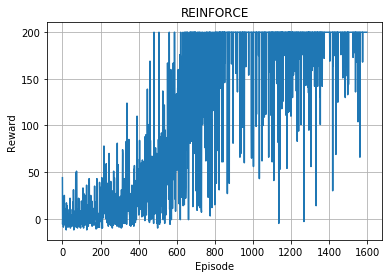

In [ ]:
import matplotlib.pyplot as plt

def plot(x, y, name):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    
    ax.set(xlabel='Episode', ylabel='Reward', title=name)
    ax.grid()

    fig.savefig("%s.png" % name)
    plt.show()
    
plot(range(episode), plot_history_episode_rewards, 'REINFORCE')

In [ ]:
while True:
    do_rollout(env=env, policy=policy, render=True)